# Tutorial: Signal Extraction from Noisy Data

This tutorial demonstrates how to use `gwexpy` to detect and extract a weak signal buried in noise.
We will simulate a scenario where a monochromatic signal (sine wave) is hidden within Gaussian noise.

**Workflow:**
1.  **Data Generation**: Simulate a noisy time series.
2.  **Inspection**: Visualize the raw data (Time Domain).
3.  **Spectral Analysis**: Use Amplitude Spectral Density (ASD) to identify the signal frequency.
4.  **Filtering**: Apply a bandpass filter to extract the signal.
5.  **Parameter Estimation**: Fit the extracted signal to quantify its properties.


In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import numpy as np
import matplotlib.pyplot as plt

from gwexpy import TimeSeries, FrequencySeries
from gwexpy.fitting import enable_series_fit

# Enable .fit() method on Series objects
enable_series_fit()


## 1. Data Generation

Let's simulate 32 seconds of data at a sample rate of 4096 Hz.
We'll inject a sine wave at **123.4 Hz** with a small amplitude into Gaussian white noise.


In [2]:
# Parameters
duration = 32  # seconds
sample_rate = 4096  # Hz
signal_freq = 123.4  # Hz
signal_amp = 0.5
noise_std = 5.0  # Noise is much larger than signal

# Time array
t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)

# Generate Noise (White Gaussian)
# In a real scenario, this would be your measurement data
noise = np.random.normal(0, noise_std, size=len(t))

# Generate Signal
clean_signal = signal_amp * np.sin(2 * np.pi * signal_freq * t)

# Combine
data = noise + clean_signal

# Create TimeSeries object
ts = TimeSeries(data, t0=0, sample_rate=sample_rate, name="Noisy Data", unit="V")

print(ts)


TimeSeries([ 1.04389445, -2.93941348, -6.03451914, ...,
            -3.98580134, -0.07367239,  0.26988994]
           unit: V,
           t0: 0.0 s,
           dt: 0.000244140625 s,
           name: Noisy Data,
           channel: None)


## 2. Time Domain Inspection

If we plot the raw time series, the signal is buried in noise and invisible to the naked eye.


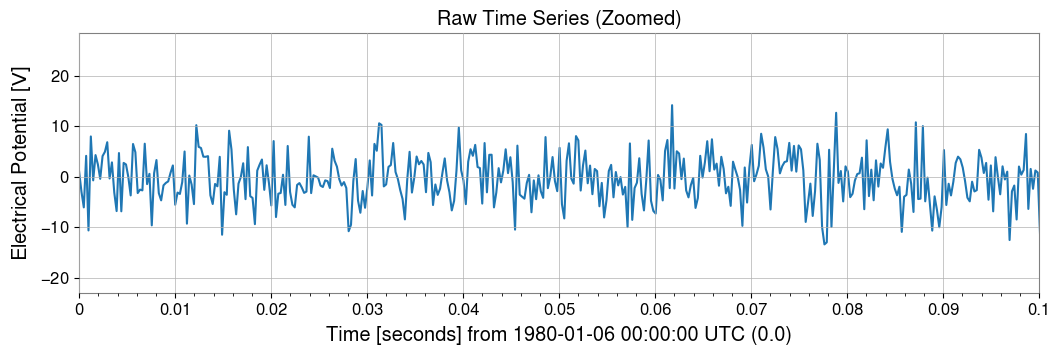

In [3]:
plot = ts.plot()
plot.gca().set_xlim(0, 0.1)  # Zoom in to 0.1s
plot.gca().set_title("Raw Time Series (Zoomed)")
plt.show()


## 3. Spectral Analysis

To find the hidden periodic signal, we calculate the Amplitude Spectral Density (ASD).
White noise has a flat ASD, while the sine wave should appear as a sharp peak.


In [4]:
# Calculate ASD
# fftlength=4 means we average 4-second chunks to reduce variance
asd = ts.asd(fftlength=4, method="welch")

plot = asd.plot()
plot.gca().set_xlim(10, 1000)
plot.gca().set_yscale('log')
plot.gca().set_title("Amplitude Spectral Density")
plt.show()


AttributeError: 'TimeSeries' object has no attribute '_check_regular'

## 4. Filtering

Once we identify the peak around 123 Hz, we can apply a **bandpass filter** to suppress the noise outside this frequency range.
Let's filter between 110 Hz and 130 Hz.


In [ ]:
# Bandpass filter
filtered_ts = ts.bandpass(110, 130).crop(1, 1.1)

# Compare raw vs filtered
plot = filtered_ts.plot()
plot.gca().set_title("Filtered Time Series (Signal Recovered)")
plt.show()

# Verify amplitude stability
print(f"Standard Deviation of filtered data: {filtered_ts.std().value:.4f}")
print(f"Expected RMS of sine wave (A/sqrt(2)): {signal_amp/np.sqrt(2):.4f}")


## 5. Parameter Estimation (Fitting)

Finally, we can fit a sine wave model to the filtered data to estimate the amplitude and frequency precisely.
Alternatively, we can fit a Gaussian or Lorentzian to the peak in the frequency domain.

Here, let's try a simple fit in the time series using `gwexpy.fitting`.
(Note: Generic sine fitting requires good initial guesses).


In [ ]:
# Define a sine model for fitting
def sine_model(t, amp, freq, phase):
    return amp * np.sin(2 * np.pi * freq * t + phase)

# Crop a small segment for fitting to speed it up and visualize
segment = filtered_ts

# Initial guess via inspection
p0 = {'amp': 0.5, 'freq': 123, 'phase': 0} 
limits = {'freq': (110, 130), 'amp': (0.1, 5)}

# Perform fit
# Note: 'fit' method is available because we called enable_series_fit()
result = segment.fit(sine_model, p0=p0, limits=limits, sigma=0.01)

print(result)

# Plot data and best fit
ax = result.plot()
plt.show()
